In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random


Функция создания графа

In [2]:
def create_graph(graph, n, m):
    nodes = list(range(n))
    graph.add_nodes_from(nodes)
    edges = []
    if m > n*(n-1)/2:
        m = n*(n-1)/2
    while len(edges) != m:
        nodes1 = nodes.copy()
        n1 = random.choice(nodes1)
        nodes1.pop(n1)
        n2 = random.choice(nodes1)
        if (n1, n2) not in edges and (n2, n1) not in edges:
            edges.append((n1, n2))
    graph.add_edges_from(edges)


Получение диаметра графа

In [3]:
def get_diameter(graph):
    return nx.diameter(graph) if len(graph.nodes) > 0 else 0


Критерии разрушения

In [4]:
def connection_criteria(graph):
    return nx.is_k_edge_connected(graph, k=1)


In [5]:
def no_full_destraction_criteria(graph):
    return len(graph.nodes) > 0


Функция отрисовки графа

In [6]:
def draw(graph, i=0, new_nodes=None, edges=None):
    if edges is None:
        edges = []
    if new_nodes is None:
        new_nodes = []
    if no_full_destraction_criteria(graph):
        plt.figure(i, figsize=(4, 4))
        pos = nx.circular_layout(graph)
        nx.draw(graph,
                pos,
                node_color='orange',
                node_size=400,
                with_labels=True)
        if len(new_nodes) > 0:
            nx.draw_networkx_nodes(graph,
                                   pos,
                                   nodelist=new_nodes,
                                   node_size=400,
                                   alpha=0.7,
                                   linewidths=4,
                                   node_color="red")
            nx.draw_networkx_edges(graph,
                                   pos,
                                   edgelist=edges,
                                   edge_color="red")


## Создание графа малого мира

In [7]:
n = 10   # начальное количество вершин
m = 20   # начальное количество рёбер
graph = nx.Graph()
# проверка на изначальную связанность
while not nx.is_k_edge_connected(graph, k=1):
    create_graph(graph, n, m)


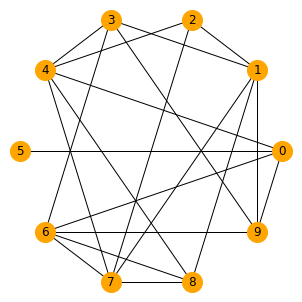

In [8]:
draw(graph)


Функция добавления рёбер на итерации

In [9]:
def add_edges(graph, nodes_add, min_m_add=2, diameter_range=None):
    graph_main = graph.copy()
    if diameter_range is None:
        diameter_range = [6]
    edges = []
    while len(edges) < min_m_add or not connection_criteria(graph):
        n1 = random.choice(list(graph.nodes))
        n2 = random.choice(nodes_add)
        if (n1, n2) not in edges and (n2, n1) not in edges:
            sorted_components = sorted(
                nx.connected_components(graph), key=len, reverse=True)
            graph = nx.Graph(graph.subgraph(sorted_components[0]))
            if get_diameter(graph) in diameter_range:
                graph = graph_main
                graph1 = graph.copy()
                graph1.add_edge(n1, n2)
                sorted_components = sorted(
                    nx.connected_components(graph1), key=len, reverse=True)
                graph1 = nx.Graph(graph1.subgraph(sorted_components[0]))
                if get_diameter(graph1) in diameter_range:
                    graph.add_edge(n1, n2)
                    edges.append((n1, n2))
            else:
                graph = graph_main
                graph.add_edge(n1, n2)
                edges.append((n1, n2))
    return graph, edges


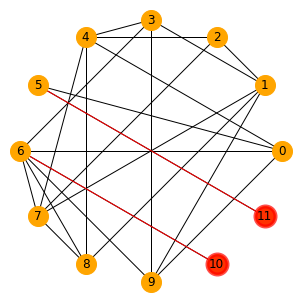

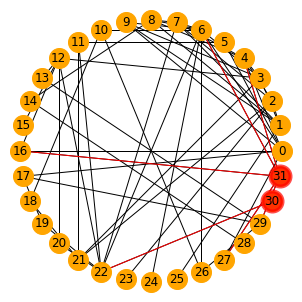

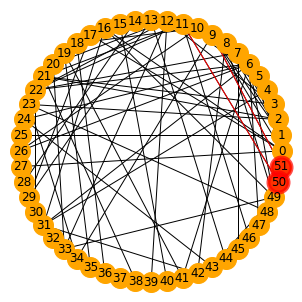

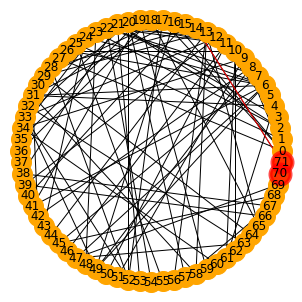

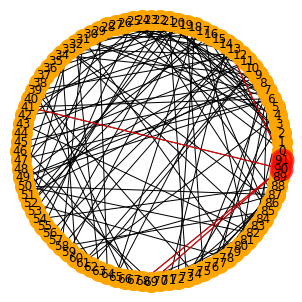

In [10]:
n_add = 2  # количество вершин, добавляемых на каждой итерации
min_m_add = 2  # минимальное  количество рёбер, добавляемых на каждой итерации
i = 0  # номер итерации
diameter_range = list(range(5, 8))
statistics = {i: {'diameter': get_diameter(
    graph), 'n_nodes': len(graph.nodes)}}
while len(graph.nodes) < 100 or get_diameter(graph) not in diameter_range:
    nodes_add = list(range(len(graph.nodes), len(graph.nodes)+n_add))
    graph.add_nodes_from(nodes_add)
    graph, edges = add_edges(graph, nodes_add, min_m_add, diameter_range)
    if i % 10 == 0:
        # отрисовка каждой десятой итерации
        draw(graph, i // 10, nodes_add, edges)
    i += 1
    statistics[i] = {'diameter': get_diameter(
        graph), 'n_nodes': len(graph.nodes)}


Визуализация статистики

In [11]:
diameter_y = []
n_nodes_y = []
for val in statistics.values():
    diameter_y.append(val['diameter'])
    n_nodes_y.append(val['n_nodes'])


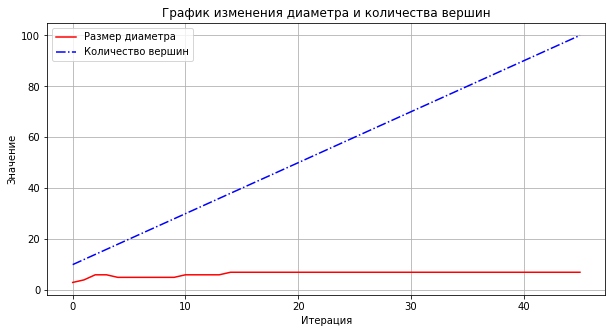

In [12]:
plt.figure(figsize=(10, 5))
plt.xlabel('Итерация')
plt.ylabel('Значение')
plt.title('График изменения диаметра и количества вершин')
plt.grid(True)
plt.plot(statistics.keys(), diameter_y, '-r', label='Размер диаметра')
plt.plot(statistics.keys(), n_nodes_y, '-.b', label='Количество вершин')
plt.legend(loc='best')
plt.show()


## Разрушение графа малого мира

Функция нахождения эпицентров в графе

In [13]:
def detect_epicenters(curr_load, max_load):
    return [i for i in range(len(curr_load)) if curr_load[i] >= max_load[i]]


Функция отрисовки графа с эпицентрами

In [14]:
def draw_with_epicenters(graph, curr_load, max_load, i=0):
    epicenters = detect_epicenters(curr_load, max_load)
    if len(graph.nodes) > 0:
        plt.figure(i, figsize=(7, 7))
        pos = nx.circular_layout(graph)
        labels = {}
        pos_higher = {}
        for node in graph.nodes():
            labels[node] = round(curr_load[node], 2)
            pos_higher[node] = (pos[node][0], pos[node][1]+0.2)

        nx.draw(graph,
                pos,
                node_color='orange',
                node_size=800,
                with_labels=True)
        nx.draw_networkx_labels(graph,
                                pos_higher,
                                labels=labels,
                                bbox=dict(facecolor='white',
                                          edgecolor='Lavender', pad=5.0)
                                )
        if len(epicenters) > 0:
            nx.draw_networkx_nodes(graph,
                                   pos,
                                   nodelist=epicenters,
                                   node_size=500,
                                   alpha=0.7,
                                   linewidths=4,
                                   node_color="red")
        x_values, y_values = zip(*pos.values())
        y_max = max(y_values)
        y_min = min(y_values)
        y_margin = 0.5
        plt.ylim(y_min - y_margin, y_max + y_margin)


Основная функция нагрузки системы

In [15]:
# k - количество эпицентров в начальный момент, draw_process - иллюстрировать процесс
def overload_system(graph, curr_load, max_load, k, draw_process=False):
    # создание эпиентров нагрузки
    epicenters = np.random.choice(range(n), k, replace=False)
    for epi in epicenters:
        curr_load[epi] = max_load[epi]
    i = 0   # количество итераций
    statistics = {i: {'diameter': get_diameter(graph),
                      'no_full_destraction': no_full_destraction_criteria(graph),
                      'connection': connection_criteria(graph)}}
    # проверка критериев отказа
    while len(epicenters) > 0 and no_full_destraction_criteria(graph):
        if draw_process:
            draw_with_epicenters(graph, curr_load, max_load, i)
        epicenters = detect_epicenters(curr_load, max_load)
        i += 1
        for epi in epicenters:  # поиск связанных узлов для будущего распределение нагрузки
            connected_nodes = []
            for edge in graph.edges():
                if epi in edge:
                    connected_node = edge[1 - edge.index(epi)]
                    if curr_load[connected_node] != -1:
                        connected_nodes.append(connected_node)

            delta = curr_load[epi] / len(connected_nodes)
            curr_load[epi] = -1
            for ed in connected_nodes:  # распределение нагрузки
                curr_load[ed] += delta
        graph.remove_nodes_from(epicenters)
        connection_cr = connection_criteria(graph)
        # берем большую компоненту в качесте основного графа
        if no_full_destraction_criteria(graph):
            sorted_components = sorted(
                nx.connected_components(graph), key=len, reverse=True)
            graph = nx.Graph(graph.subgraph(sorted_components[0]))
            for ii in range(len(curr_load)):
                if ii not in graph.nodes:
                    curr_load[ii] = -1
        statistics[i] = {'diameter': get_diameter(graph),
                         'no_full_destraction': no_full_destraction_criteria(graph),
                         'connection': connection_cr}

    # возвращение статистики
    return statistics


In [16]:
n = len(graph.nodes)   # количество вершин
m = len(graph.edges)   # количество рёбер
max_load = np.full(n, 10)  # максимальная загруженность
curr_load = np.random.randint(1, 8, size=(n)).astype(
    float)  # текущая загруженность


Нагрузка эпицентрами

<ipython-input-15-ad6a18a4a72d>:25: RuntimeWarning: divide by zero encountered in double_scalars
  delta = curr_load[epi] / len(connected_nodes)


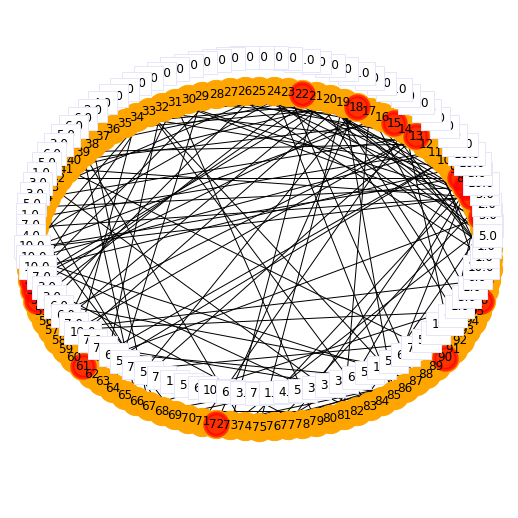

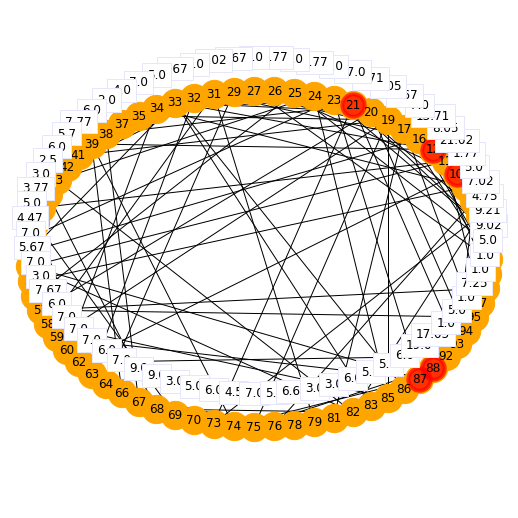

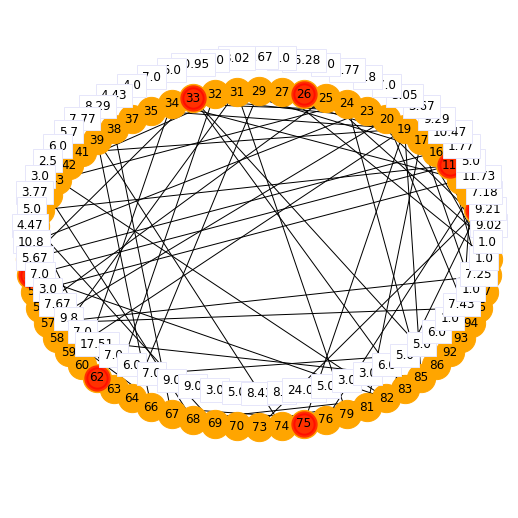

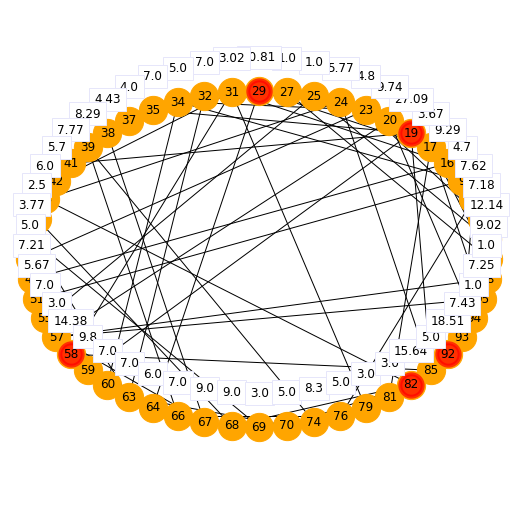

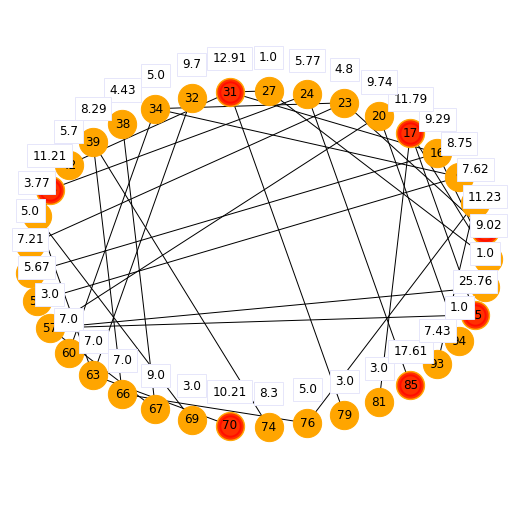

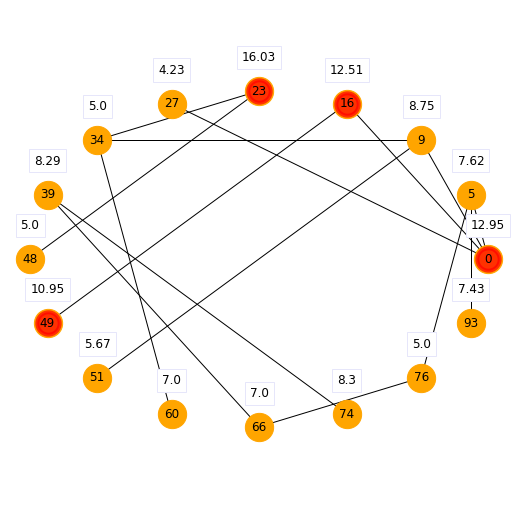

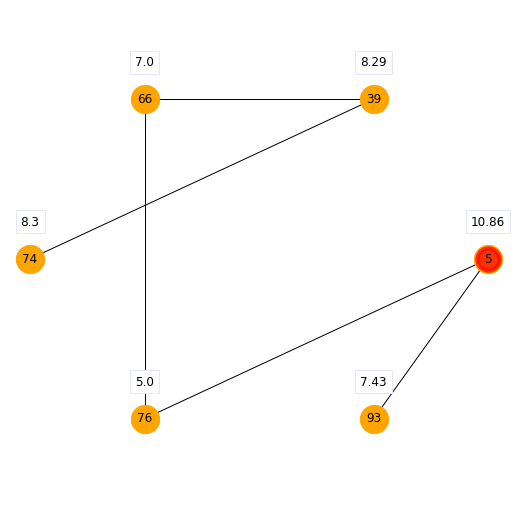

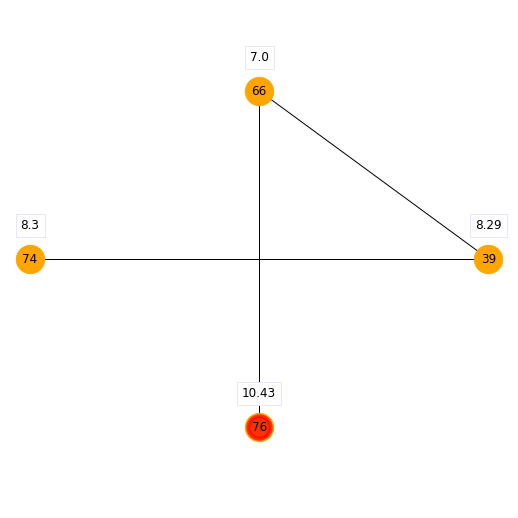

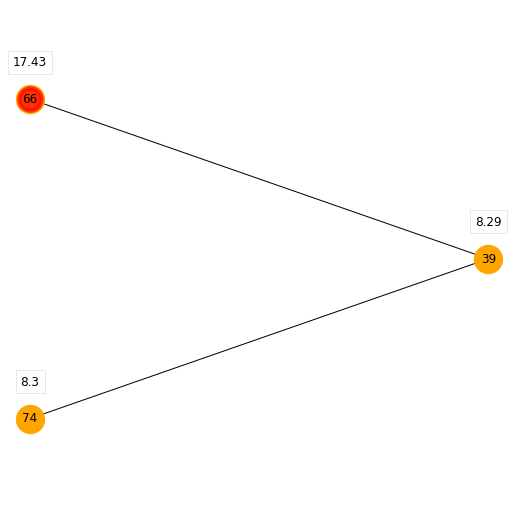

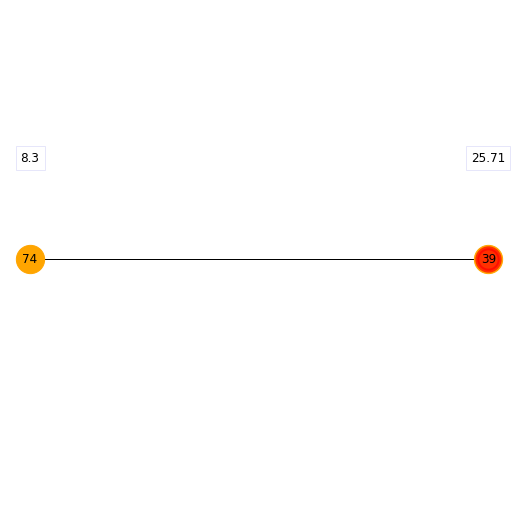

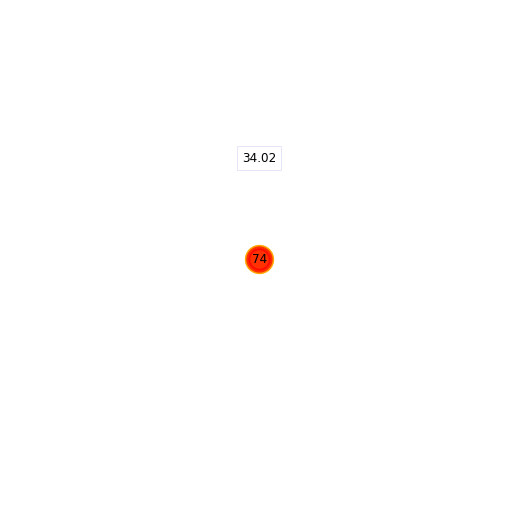

In [17]:
res = overload_system(graph.copy(), curr_load, max_load, 15, True)


Обработка и визуализация статистики

In [18]:
def statistics_chart(statistics):
    diameter_y = []
    destracted = []
    notconnected = []
    for k, line in statistics.items():
        diameter_y.append(line['diameter'])
        if not line['no_full_destraction']:
            destracted.append(k)
        if not line['connection']:
            notconnected.append(k)
    plt.figure(figsize=(10, 5))
    plt.xlabel('Итерация')
    plt.ylabel('Диаметр')
    plt.title('График диаметра на каждом такте')
    plt.grid(True)
    plt.plot(statistics.keys(), diameter_y, '--Dr', label='Размер диаметра')
    plt.scatter(notconnected, len(notconnected) *
                [0], s=350, c='b', label='Распад на компонеты')
    plt.scatter(destracted, len(destracted) *
                [0], s=200, c='yellow', label='Система полностью разрушена')
    plt.legend()
    plt.show()


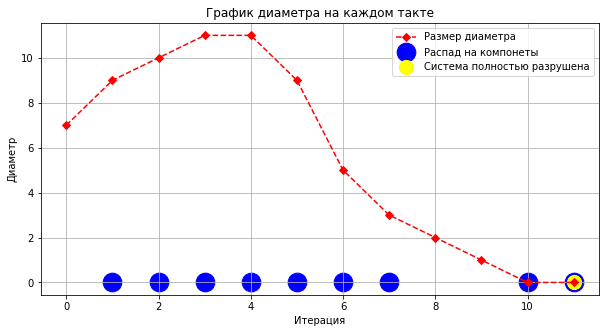

In [19]:
statistics_chart(res)


## Разрушение случайного графа

In [20]:
curr_load = np.random.randint(1, 8, size=(n)).astype(
    float)  # текущая загруженность
graph_rand = nx.Graph()
# проверка на изначальную связанность
while not nx.is_k_edge_connected(graph_rand, k=1):
    create_graph(graph_rand, n, m)


Нагрузка эпицентрами

<ipython-input-15-ad6a18a4a72d>:25: RuntimeWarning: divide by zero encountered in double_scalars
  delta = curr_load[epi] / len(connected_nodes)


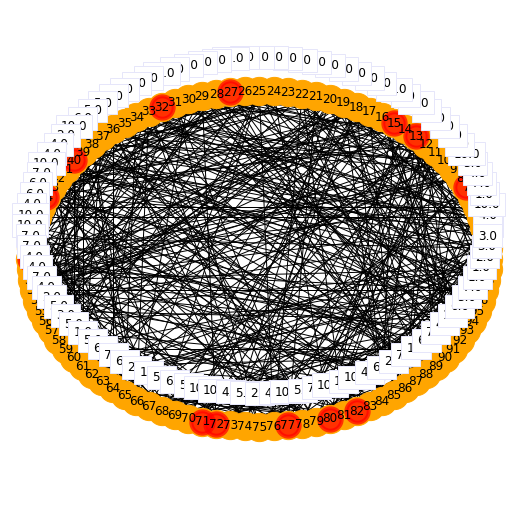

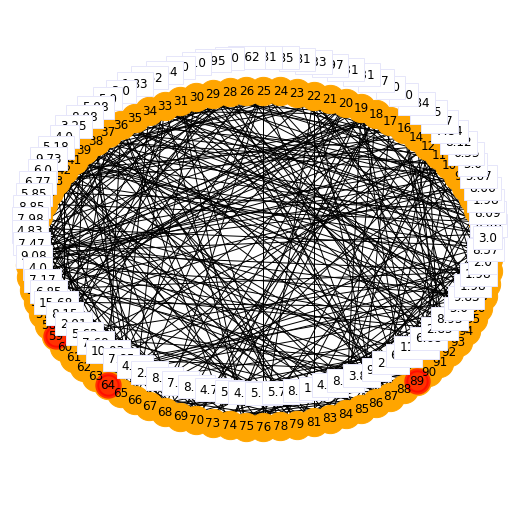

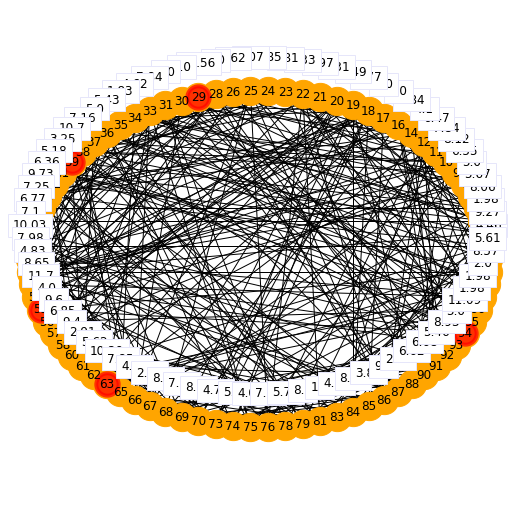

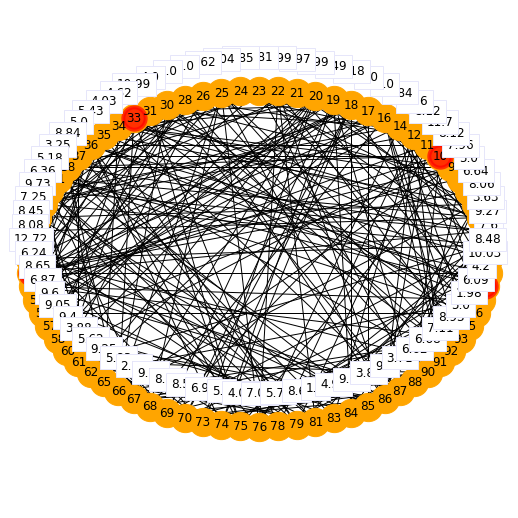

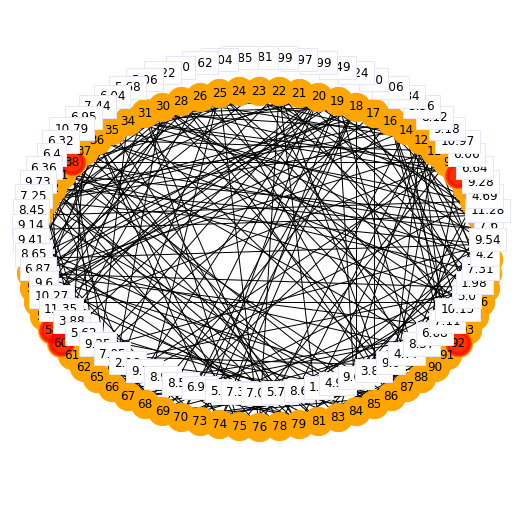

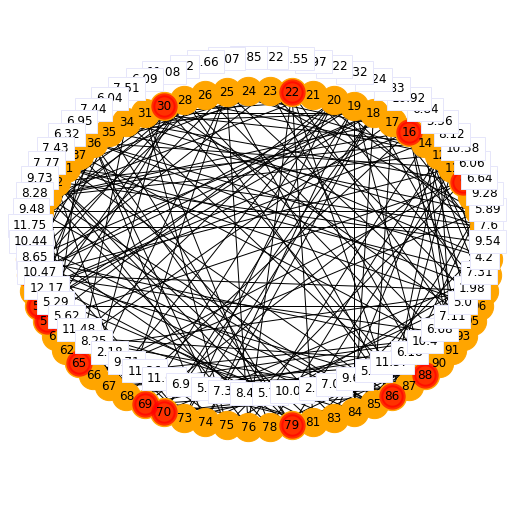

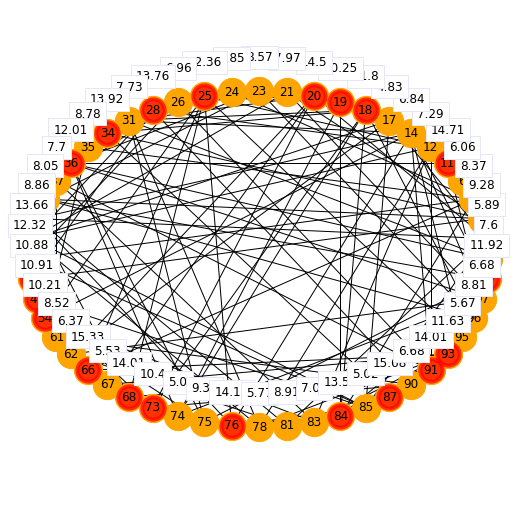

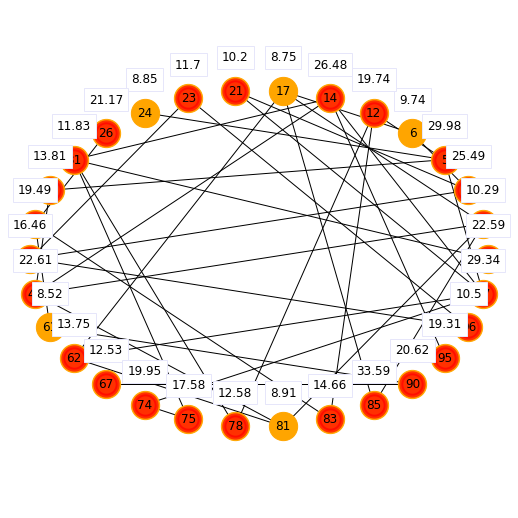

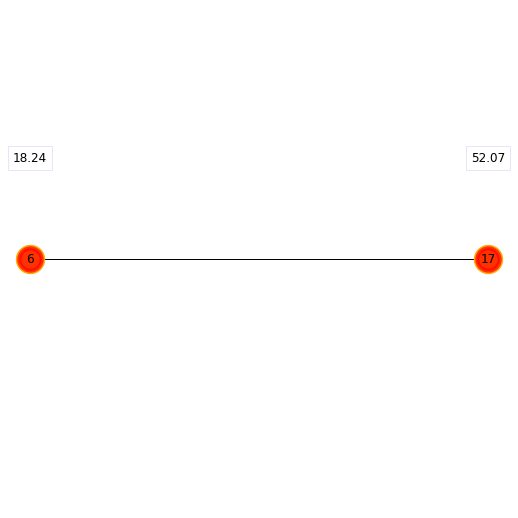

In [21]:
res_rand = overload_system(graph_rand.copy(), curr_load, max_load, 15, True)


Обработка и визуализация статистики

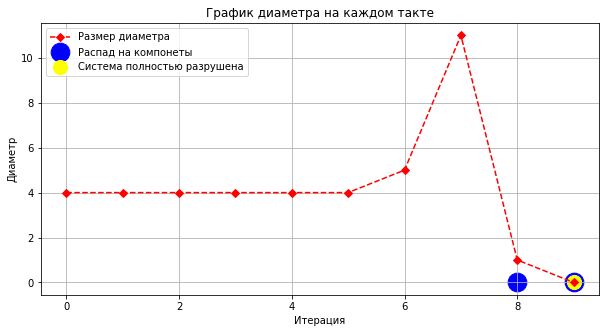

In [22]:
statistics_chart(res_rand)


# Сравнение

Распад малого мира


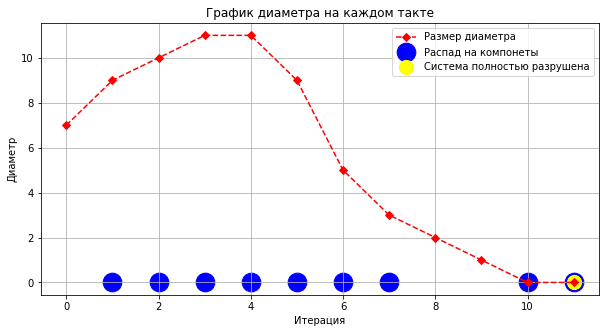

Распад случайного графа


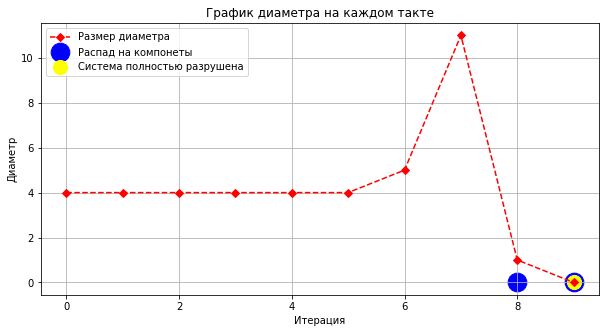

In [24]:
print('Распад малого мира')
statistics_chart(res)
print('Распад случайного графа')
statistics_chart(res_rand)

При 15 начальных эпицентрах малый мир распадается за 11 итераций, а случайный граф за 9 итераций. При этом малый мир 9 раз распадался на компоненты, а случайны только 2 раза. В данном примере размер диаметра у малого мира изменялся более плавно